In [1]:
# this one use 200 brackets as input.
# after smoothing, we do resample to 50 brackets.

In [2]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.insert(0, '../scripts/')

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 196

In [4]:
%load_ext autoreload
%autoreload 1

In [5]:
%aimport shapeslib
%aimport etllib
%aimport smoothlib

# Methodology overview

See this [doc](https://docs.google.com/document/d/1-ro2bg-VSg-i-SxCW4_UadS2HPFAbFjc3PwBww134xY/edit)

# Step1: load all source files

The source files downloaded from povcal have following format (check the [doc](http://iresearch.worldbank.org/PovcalNet/docs/introduction_to_povcalnet.pdf) for more detail):

In [6]:
s000 = pd.read_csv('../source/income_mountain/0000.csv')
s000.head()

,isInterpolated,useMicroData,CountryCode,CountryName,RegionCode,CoverageType,RequestYear,DataYear,DataType,PPP,...,Decile1,Decile2,Decile3,Decile4,Decile5,Decile6,Decile7,Decile8,Decile9,Decile10
0,0,1,ALB,Albania,XX,N,1981,1996.00,X,54.652580,...,0.038630,0.05289,0.06379,0.07322,0.08380,0.09355,0.10820,0.1247,0.1490,0.2122
1,0,0,DZA,Algeria,XX,N,1981,1988.00,X,31.517970,...,0.027000,0.03839,0.04869,0.05868,0.06898,0.08035,0.09398,0.1124,0.1434,0.3281
2,0,1,AGO,Angola,XX,N,1981,2000.21,X,80.931800,...,0.009832,0.02195,0.03342,0.04495,0.05663,0.07049,0.08808,0.1135,0.1587,0.4025
3,1,1,ARG,Argentina,XX,U,1981,NaN,Y,3.161164,...,-1.000000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.0000,-1.0000,-1.0000
4,0,0,ARM,Armenia,XX,N,1981,1996.00,Y,165.629000,...,0.022960,0.03236,0.04186,0.05187,0.06291,0.07575,0.09185,0.1144,0.1538,0.3522


there are 201 csv files downloaded, where the file number 0000-0200 means a poverty line defined as following: 

In [7]:
all_brackets = np.logspace(-7, 13, 201, endpoint=True, base=2)
brackets_delta = 0.1  # it's (13 - (-7)) / 200

In [8]:
all_brackets[0]

0.0078125

In [9]:
s000['PovertyLine'].unique()

array([0.0078125])

In [10]:
all_brackets[200]

8192.0

In [11]:
len(all_brackets)

201

In [12]:
def step1():
    res = dict()
    for f in os.listdir('../source/income_mountain'):
        if f.endswith('.csv'):
            fn = f.split('.')[0]
            bracket = fn.lstrip('0')
            if bracket == '':
                bracket = 0
            else:
                bracket = int(bracket)
            res[bracket] = etllib.load_file_preprocess(os.path.join('../source/income_mountain', f))
    return res

In [13]:
res1 = step1()

In [14]:
len(res1.keys())

201

In [15]:
res1[0]

,,,CountryName,Mean,HeadCount,ReqYearPopulation
country,year,coverage_type,,,,
ALB,1981,N,Albania,220.77280,0.000000,2.726056
DZA,1981,N,Algeria,240.87570,0.000000,19.824301
AGO,1981,N,Angola,166.38240,0.000000,8.640446
ARG,1981,U,Argentina,671.63370,0.002289,23.609667
ARM,1981,N,Armenia,285.08040,0.000130,3.148096
...,...,...,...,...,...,...
VNM,2019,N,Vietnam,348.77690,0.000000,96.462106
PSE,2019,N,West Bank and Gaza,328.30880,0.000000,4.685306
YEM,2019,N,"Yemen, Republic of",70.69390,0.000000,29.161922


# step 2: remove NaNs

In [16]:
def step2(res1):
    res = dict()
    nans = set()
    for k, df in res1.items():
        if df['HeadCount'].hasnans:
            idxs = df[pd.isnull(df['HeadCount'])].index.unique()
            nans = nans.union(set(idxs))
        res[k] = df.dropna(how='any', subset=['HeadCount'])
    if len(nans) > 0:
        print("WARNING: NaNs detected in these datapoints, dropping them")
        for i in nans:
            print(i)
    return res

In [17]:
res2 = step2(res1)

('IND', 2018, 'U')
('IND', 2019, 'U')
('IND', 2018, 'A')
('IND', 2018, 'R')
('IND', 2019, 'A')
('IND', 2019, 'R')


In [18]:
len(res2.keys())

201

# Step 3: get bracket head count

In [19]:
# step3: subtract and get bracket head count, and concat them to DataFrame
def step3(res2):
    res3 = list()
    for i in range(1, 201):
        df1 = res2[i]
        df2 = res2[i-1]
        df3 = df1[['HeadCount']] - df2[['HeadCount']]
        df3['bracket'] = i - 1
        df3 = df3.set_index('bracket', append=True)
        res3.append(df3)
    return pd.concat(res3)

In [20]:
res3 = step3(res2)

In [21]:
res3

,,,,HeadCount
country,year,coverage_type,bracket,
ALB,1981,N,0,0.000000e+00
DZA,1981,N,0,0.000000e+00
AGO,1981,N,0,0.000000e+00
ARG,1981,U,0,3.310000e-07
ARM,1981,N,0,2.689000e-07
...,...,...,...,...
VNM,2019,N,199,0.000000e+00
PSE,2019,N,199,0.000000e+00
YEM,2019,N,199,0.000000e+00


In [22]:
res3.loc[res3.index.duplicated()].reset_index().bracket.unique()

array([], dtype=int64)

# step4: reduce noises

In [23]:
res3 = res3.sort_index()

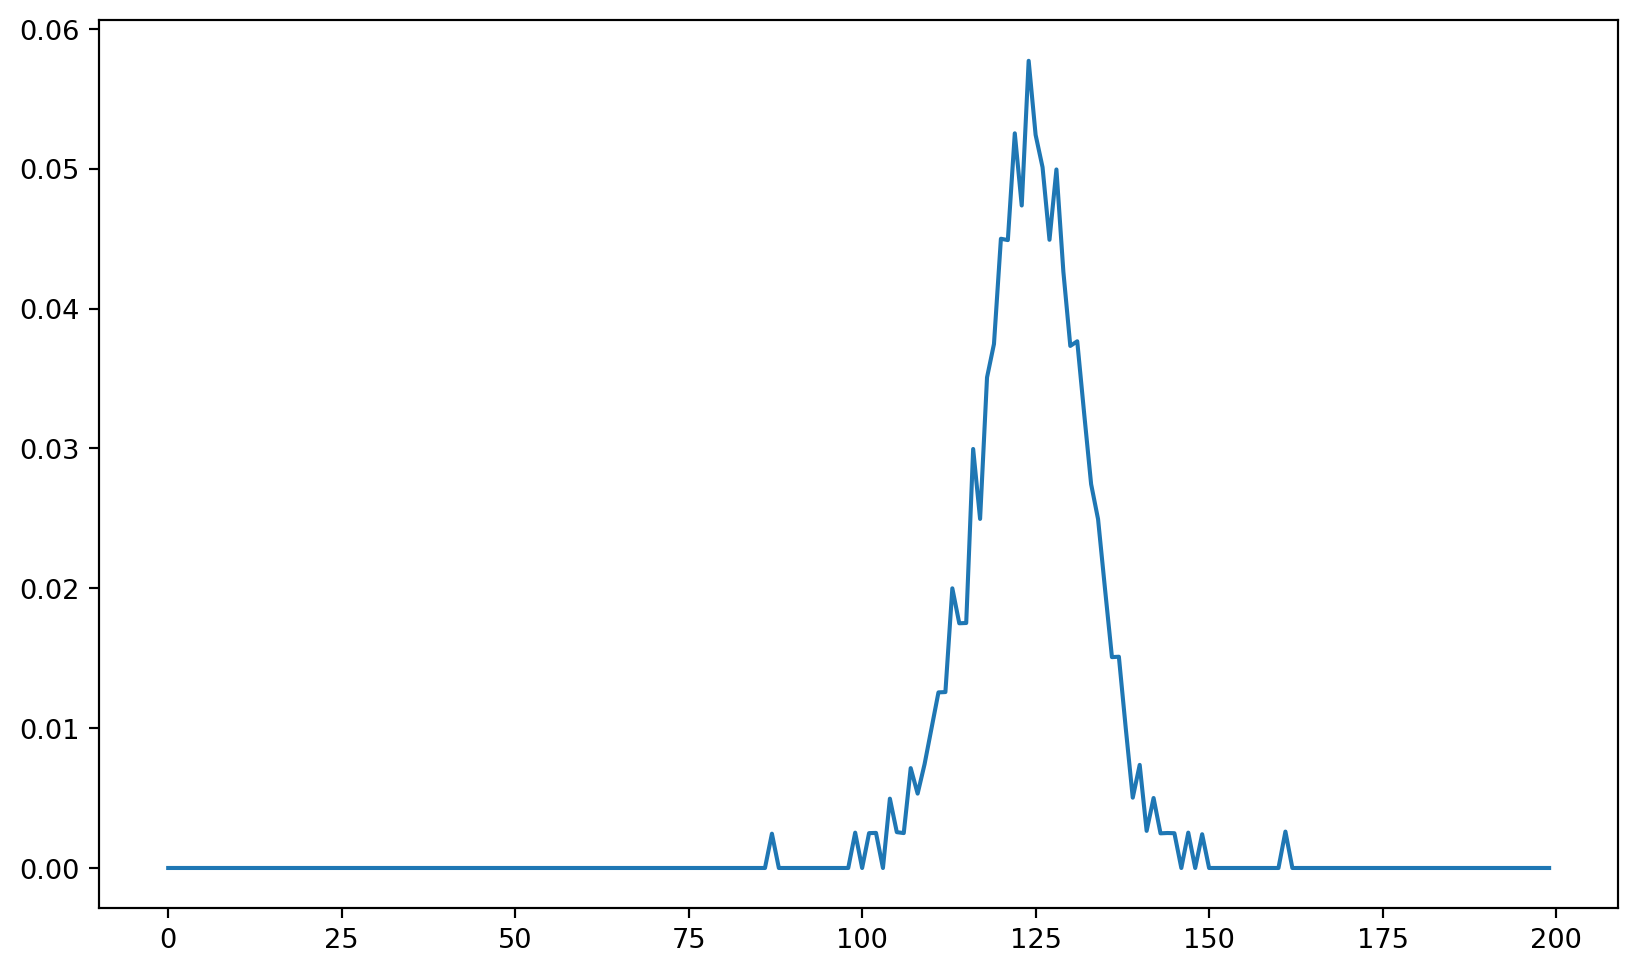

In [24]:
plt.plot(res3.loc[('DEU', 2015, 'N')])

In [25]:
# step4: reduce noises
def step4(res3):
    res4 = list()
    gs = res3.groupby(['country', 'year', 'coverage_type'])
    for g in gs.groups.keys():
        df = gs.get_group(g)
        s = df['HeadCount'].copy()
        todrop = set()
        if np.any(s < 0):  # if negative values exists
            where = np.where(s < 0)[0]
            for w in where:
                if w > 199:
                    print(g, w)
                if w != 199:
                    todrop.add(w+1)
                if w != 0:
                    todrop.add(w-1)
                todrop.add(w)
            s.iloc[list(todrop)] = np.nan
            res4.append(s)
        else:
            res4.append(s)
    return pd.concat(res4)

In [26]:
res4 = step4(res3)

In [27]:
res4 = res4.sort_index()  # TODO: see if we can skip this step and not producing the unsorted warning

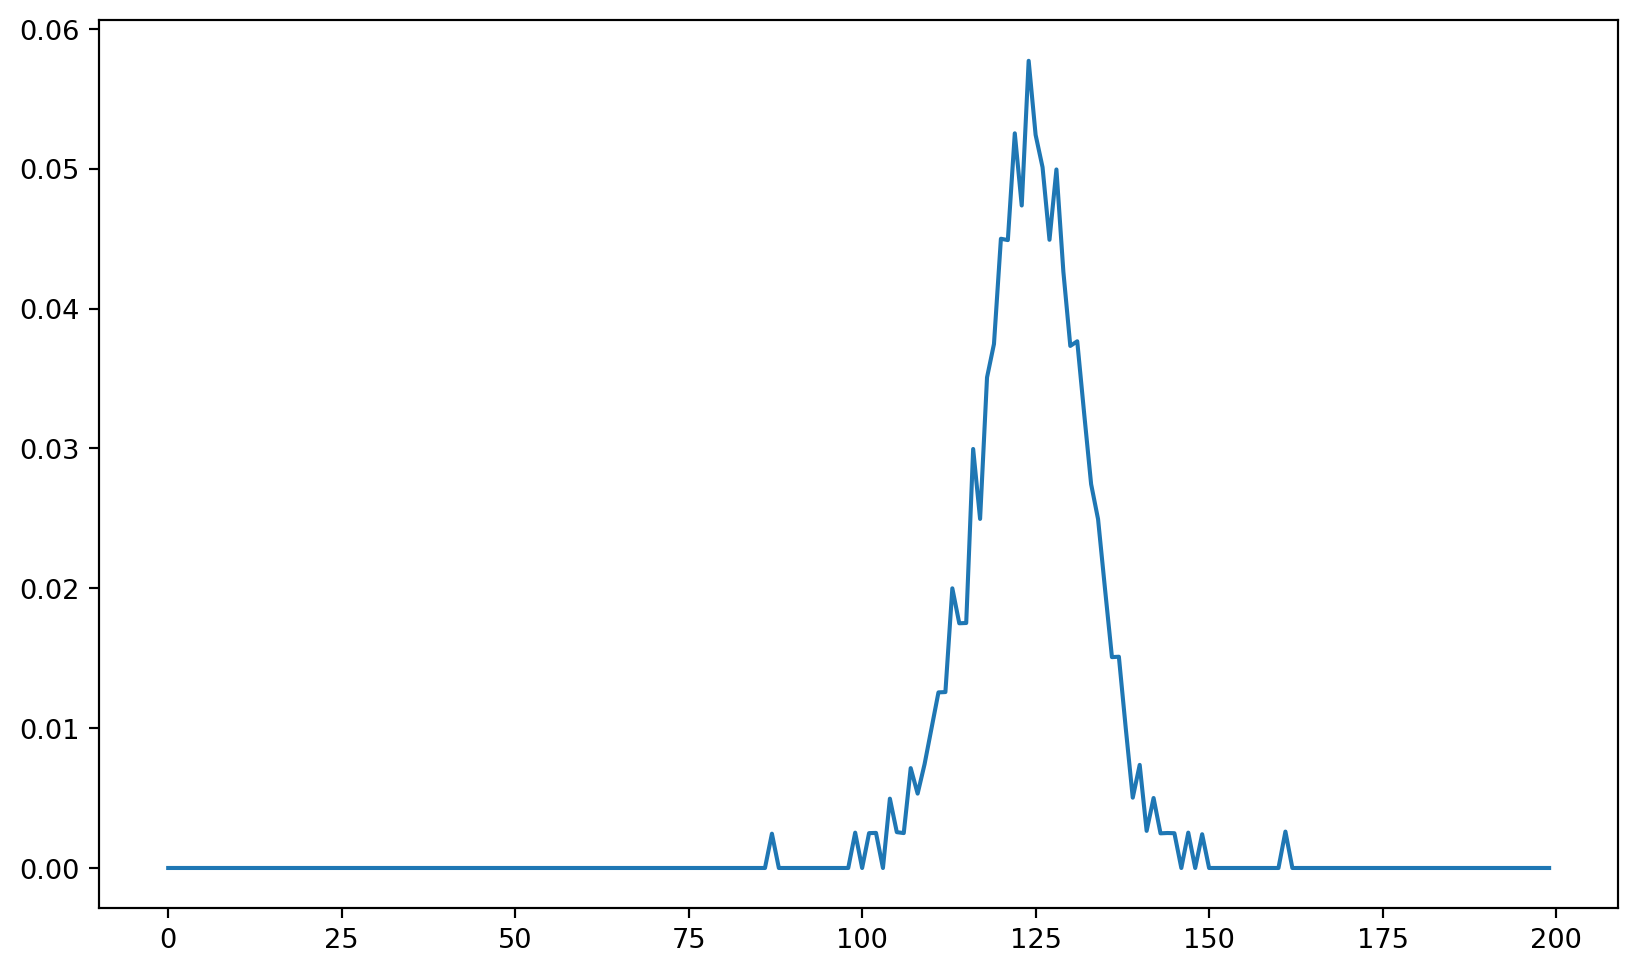

In [28]:
plt.plot(res4.loc[('DEU', 2015, 'N')])

# step5: get smoothed shape, ensure the shape sum up to 100%

TODO: add link to smoothing method doc

In [29]:
run_smooth = smoothlib.run_smooth

In [30]:
res4.index.get_level_values('country').unique()

Index(['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL',
       ...
       'UZB', 'VEN', 'VNM', 'VUT', 'WSM', 'XKX', 'YEM', 'ZAF', 'ZMB', 'ZWE'],
      dtype='object', name='country', length=168)

In [31]:
def func(x):
    """function to smooth a series"""
    run_smooth = smoothlib.run_smooth
    if x.hasnans:
        # interpolate curve if theree are nans
        x = x.interpolate()
        # if first value is nan, it won't be interpolated. we fill 0
        if pd.isnull(x.iloc[0]):
            x = x.fillna(0)
    # run smoothing, based on standard deviation
    std = x.std()
    if std < 0.010:
        res = run_smooth(x, 20, 6)
        res = run_smooth(res, 16, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 10, 1)
        res = run_smooth(res, 10, 0)
    elif std < 0.012:
        res = run_smooth(x, 20, 3)
        res = run_smooth(res, 16, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 10, 0)
        res = run_smooth(res, 8, 0)
    else:
        res = run_smooth(x, 20, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 16, 0)
        res = run_smooth(res, 10, 0)
        res = run_smooth(res, 8, 0)
    # also, make sure it will sum up to 100%
    if res.min() < 0:
        res = res - res.min()
    res = res / res.sum()
    return res

In [32]:
import warnings

In [33]:
def process_step5(ser):
    idx = ser.index
    try:
#         if ser.std() < 0.035:
#             print(idx[0])
        with warnings.catch_warnings(record=True) as w:
            s_new = func(ser)
            s_new.index = idx
            if len(w) > 0:
                print(idx[0], w[-1].category)
    except KeyboardInterrupt:
        raise
    except:
        print(idx[0])
        return pd.Series([], dtype=float)
    return s_new

In [34]:
from multiprocessing import Pool

In [35]:
POOLSIZE = 7

def step5(res4):
    gs = res4.groupby(['country', 'year', 'coverage_type'])
    to_smooth = list()
    for g, df in gs:
        to_smooth.append(df)
    print(len(to_smooth))
    with Pool(POOLSIZE) as p:
        res5 = p.map(process_step5, to_smooth)
    return pd.concat(res5)

In [36]:
res5 = step5(res4)

6639
('CAN', 1987, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('AUS', 2009, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('AUS', 2012, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('FRA', 1995, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('IND', 2010, 'R', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('NOR', 1996, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('RUS', 2015, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>
('NLD', 1993, 'N', 0) <class 'scipy.optimize._optimize.OptimizeWarning'>


In [37]:
res5

country  year  coverage_type  bracket
AGO      1981  N              0          7.153827e-06
                              1          8.619550e-06
                              2          1.029801e-05
                              3          1.214019e-05
                              4          1.423205e-05
                                             ...     
ZWE      2019  N              195        1.402410e-07
                              196        1.090947e-07
                              197        8.406808e-08
                              198        6.417809e-08
                              199        4.857008e-08
Length: 1327800, dtype: float64

0.011639479729671451


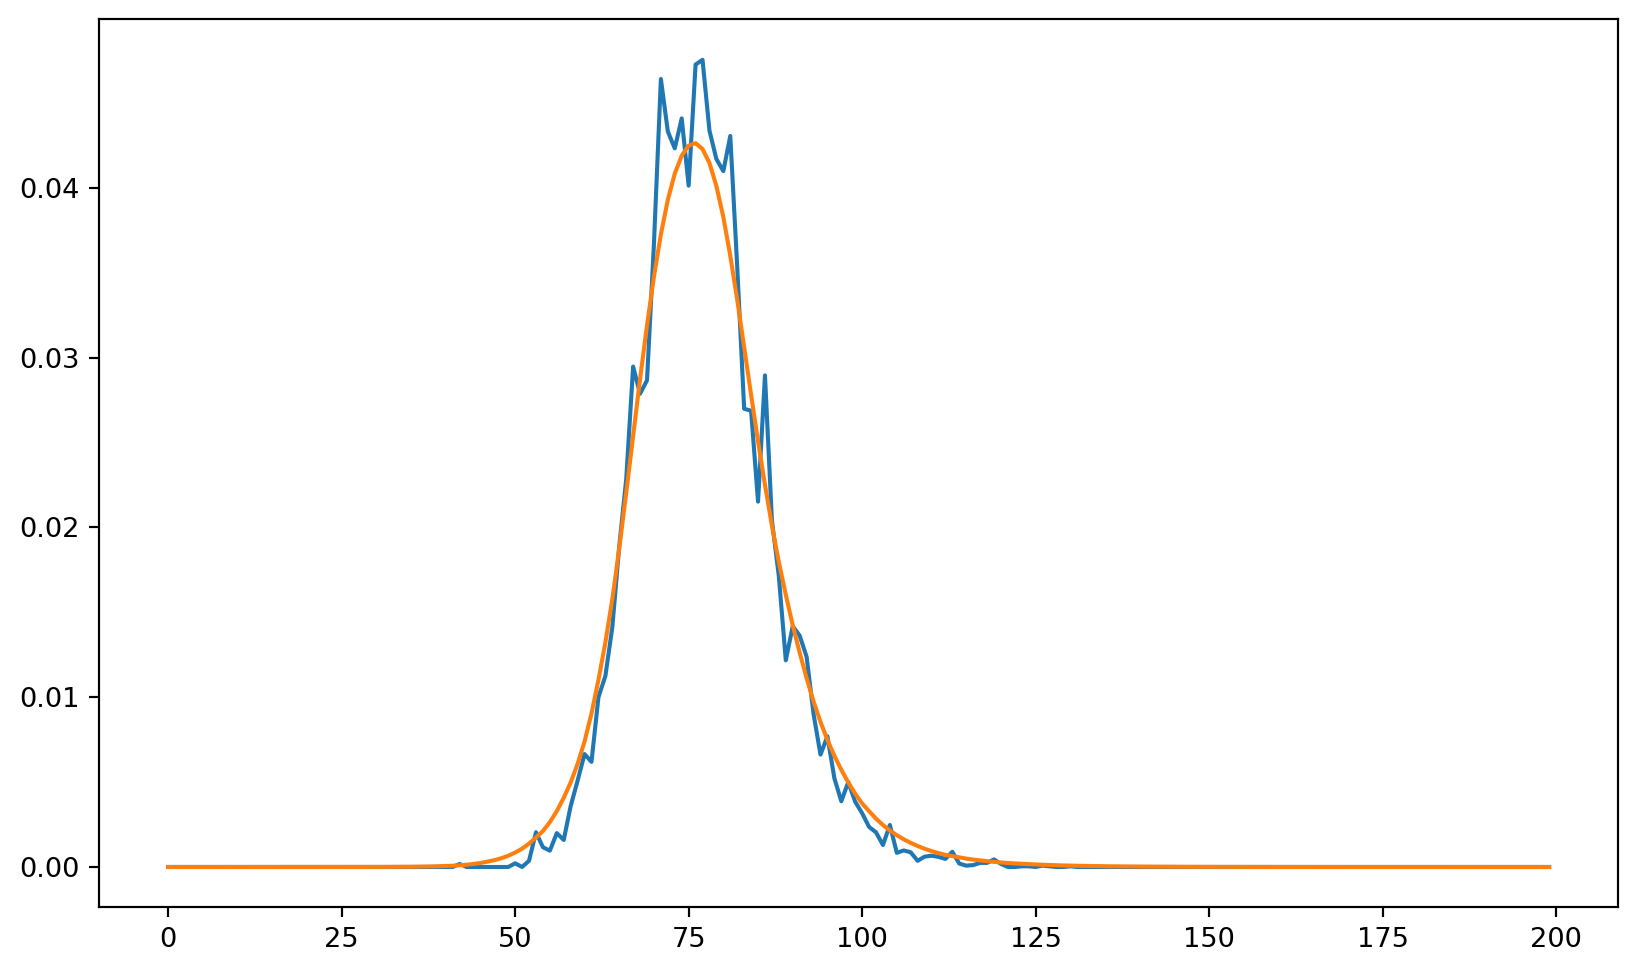

In [45]:
# check warnings

# sns.reset_defaults()

i = ('BEN', 1996, 'N')

print(res4.loc[i].std())
plt.plot(res4.loc[i])
plt.plot(res5.loc[i])

In [49]:
# since the smoothed shapes look good for these datapoints, I think we can safely ignore these warnings.

# step6: renaming and make it DDF valid
also change xkx to kos for country, to align with open-numbers namespace. xkx/kos is the only difference between wb country entities and open-numbers country entities

In [46]:
def step6(res5):
    res6 = res5.copy()
    res6.name = 'population_percentage'
    res6 = res6.reset_index()
    res6['country'] = res6['country'].map(str.lower)
    res6['country'] = res6['country'].replace({'xkx': 'kos'})
    res6['coverage_type'] = res6['coverage_type'].map(str.lower)
    return res6.set_index(['country', 'year', 'coverage_type'])

In [47]:
res6 = step6(res5)

In [48]:
res6

bracket  population_percentage
country year coverage_type                                
ago     1981 n                    0           7.153827e-06
             n                    1           8.619550e-06
             n                    2           1.029801e-05
             n                    3           1.214019e-05
             n                    4           1.423205e-05
...                             ...                    ...
zwe     2019 n                  195           1.402410e-07
             n                  196           1.090947e-07
             n                  197           8.406808e-08
             n                  198           6.417809e-08
             n                  199           4.857008e-08

[1327800 rows x 2 columns]

In [49]:
res6.groupby(['country', 'year', 'coverage_type']).count()['bracket'].unique()

array([200,   0])

In [50]:
# create a list of all avaliable povcal shapes, which is required in neighbours calculation
povcal_country_year = res6.reset_index()[['country', 'year']].drop_duplicates()

In [51]:
povcal_country_year.to_csv('../source/fixtures/povcal_country_year.csv', index=False)

In [69]:
res6.to_csv('../precomputed/current/res6.csv')

# step7: change bracket numbers

when we merge shapes, we want to align the shapes by mean income

so we should change bracket numbers so that the mean income bracket is 0

income data comes from fasttrack

In [52]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'

In [53]:
def step7(df):
    income = pd.read_csv(income_file).set_index(['country', 'time'])
    income.index.names = ['country', 'year']
    income.columns = ['income']

    res = list()
    gs = df.groupby(['country', 'year', 'coverage_type'])
    for g, gdf in gs:
        df_ = gdf.copy()
        g_ = (g[0], g[1])
        try:
            m = income.loc[g_, 'income']
        except KeyError:
            print(f"missing: {g_}")
            continue
        b = etllib.bracket_number_from_income(m)  # 200 brackets
        # b = bracket_number_from_income(m)
        df_['bracket'] = df_['bracket'] - b
        res.append(df_)

    return pd.concat(res)

In [54]:
res7 = step7(res6)

missing: ('kos', 2000)
missing: ('kos', 2001)
missing: ('kos', 2002)
missing: ('kos', 2003)
missing: ('kos', 2004)
missing: ('kos', 2005)
missing: ('kos', 2006)
missing: ('kos', 2007)
missing: ('kos', 2008)
missing: ('kos', 2009)
missing: ('kos', 2010)
missing: ('kos', 2011)
missing: ('kos', 2012)
missing: ('kos', 2013)
missing: ('kos', 2014)
missing: ('kos', 2015)
missing: ('kos', 2016)
missing: ('kos', 2017)
missing: ('kos', 2018)
missing: ('kos', 2019)


In [55]:
res7

bracket  population_percentage
country year coverage_type                                
ago     1981 n                  -94           7.153827e-06
             n                  -93           8.619550e-06
             n                  -92           1.029801e-05
             n                  -91           1.214019e-05
             n                  -90           1.423205e-05
...                             ...                    ...
zwe     2019 n                  105           1.402410e-07
             n                  106           1.090947e-07
             n                  107           8.406808e-08
             n                  108           6.417809e-08
             n                  109           4.857008e-08

[1323800 rows x 2 columns]

In [56]:
res7.to_csv('../precomputed/current/res7.csv')

# step 8: mixing shapes

we pre-computed neighbours, check the other notebook for process to compute neighbours

- 8.1 create estimate shapes
- 8.2 create shapes for povcal period
- 8.3 merge all results

In [57]:
import json
from functools import partial

In [58]:
fp = open('../source/fixtures/neighbours_list.json', 'r')
jsonstring = fp.read()

In [59]:
all_neighbours_json = json.loads(jsonstring)

In [60]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--fasttrack/ddf--datapoints--gini--by--country--time.csv'

income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['country', 'time'])

income.index.names = ['country', 'year']
gini.index.names = ['country', 'year']

income.columns = ['income']
gini.columns = ['gini']

In [61]:
income_gini = pd.concat([income, gini], axis=1)
income_gini = income_gini.dropna(how='any').sort_index()

In [62]:
known_shapes = res7.copy()
shapes_noc = known_shapes.set_index(['bracket'], append=True)

In [63]:
shapes_noc

population_percentage
country year coverage_type bracket                       
ago     1981 n             -94               7.153827e-06
                           -93               8.619550e-06
                           -92               1.029801e-05
                           -91               1.214019e-05
                           -90               1.423205e-05
...                                                   ...
zwe     2019 n              105              1.402410e-07
                            106              1.090947e-07
                            107              8.406808e-08
                            108              6.417809e-08
                            109              4.857008e-08

[1323800 rows x 1 columns]

In [64]:
def applyfunc(ser):
    ct = ser.index.get_level_values('coverage_type')
    for c in 'naur':
        if c in ct:
            return ser[ct == c]['population_percentage']

In [65]:
shapes_noc2 = shapes_noc.groupby(['country', 'year'], as_index=False).apply(applyfunc)
shapes_noc2 = shapes_noc2.reset_index(level=0, drop=True).sort_index()

In [66]:
shapes_noc2 = shapes_noc2.reset_index('coverage_type', drop=True)

In [67]:
shapes_noc2

country  year  bracket
ago      1981  -94        7.153827e-06
               -93        8.619550e-06
               -92        1.029801e-05
               -91        1.214019e-05
               -90        1.423205e-05
                              ...     
zwe      2019   105       1.402410e-07
                106       1.090947e-07
                107       8.406808e-08
                108       6.417809e-08
                109       4.857008e-08
Name: population_percentage, Length: 1277800, dtype: float64

In [68]:
shapes_noc2.to_csv('../precomputed/current/shapes_no_coverage_type.csv')

In [70]:
import constants

In [71]:
def shape_to_mountain(shape, income):
    bracket = etllib.bracket_number_from_income(income, integer=False)
    shape.index = shape.index + bracket
    # if 0 in shape.index.values:
    #     res = shape.loc[0:199]
    # else:
    #     res = shape.loc[:199]
    # if len(res) != 200:
        # print(f'not enough points in mixed shape: {idx}')
        # new_idx = pd.Index(range(200))
        # res = shape.reindex(new_idx, fill_value=0)
    res = shape.copy()
    return res


def get_estimated_mountain(idx, income, known_shapes, all_country_year, neighbours, n=50):
    country, year = idx
    wpov, was = constants.all_weights[year]

    first_known_shape = shapeslib.get_nearest_known_shape(country, year, known_shapes)
    if first_known_shape is None:
        return None

    if wpov == 1:
        mixed_shape = first_known_shape
    elif wpov == 0:
        mixed_shape = get_average_shape2(country, year, known_shapes, all_country_year, neighbours)
    else:
        average_shape = get_average_shape2(country, year, known_shapes, all_country_year, neighbours)
        mixed_shape = shapeslib.merge_nshapes_with_weights([first_known_shape, average_shape], (wpov, was))

    return shape_to_mountain(mixed_shape, income)


In [72]:
# get_estimated_mountain = shapeslib.get_estimated_mountain
# shape_to_mountain = shapeslib.shape_to_mountain
get_average_shape2 = shapeslib.get_average_shape2
get_income_gini = shapeslib.get_income_gini

# bracket_number_from_income = etllib.bracket_number_from_income

In [73]:
unknown_list = list()

all_countries = income_gini.index.get_level_values(0).unique()
known_countries = shapes_noc.index.get_level_values(0).unique()

for country in all_countries:
    if country not in known_countries:
        unknown_list.append(country)
        print(f'{country} not available in povcal')

afg not available in povcal
and not available in povcal
atg not available in povcal
bhr not available in povcal
bhs not available in povcal
brb not available in povcal
brn not available in povcal
cub not available in povcal
dma not available in povcal
eri not available in povcal
gnq not available in povcal
grd not available in povcal
hkg not available in povcal
khm not available in povcal
kna not available in povcal
kwt not available in povcal
lby not available in povcal
mco not available in povcal
mhl not available in povcal
nzl not available in povcal
omn not available in povcal
plw not available in povcal
prk not available in povcal
qat not available in povcal
sau not available in povcal
sgp not available in povcal
smr not available in povcal
vct not available in povcal


In [74]:
known_list = known_shapes.index.droplevel('coverage_type').values.tolist()

In [75]:
all_country_year = list(zip(shapes_noc2.index.get_level_values(0), shapes_noc2.index.get_level_values(1)))
all_country_year = pd.Series(all_country_year, index=shapes_noc2.index)

In [76]:
def fix_column_names(k, df):
    country, year = k
    # print(country, year)
    df.index.name = 'bracket'
    df.name = 'income_mountain'
    df = df.reset_index()
    df['country'] = country
    df['year'] = year
    df = df.set_index(['country', 'year', 'bracket'])
    return df

In [77]:
def process_step7(i, skip_list, shape_known_list):
    country, year = i
    if country in unknown_list: 
        # only use Average Shapes
        income, _ = get_income_gini(i, income_gini)
        average_shape = get_average_shape2(country, year, shapes_noc2, all_country_year, all_neighbours_json)
        res = shape_to_mountain(average_shape, income)
        return fix_column_names(i, res)
    if i not in shape_known_list:
        income, _ = get_income_gini(i, income_gini)
        res = get_estimated_mountain(i, income, shapes_noc2, all_country_year, all_neighbours_json)
        # res = shapeslib.get_estimated_mountain(i, shapes, income_gini, resample=False) 
        return fix_column_names(i, res)

In [78]:
run = partial(process_step7, skip_list=unknown_list, shape_known_list=known_list)

In [79]:
POOLSIZE = 7
with Pool(POOLSIZE) as p:
    estimated = p.map(run, income_gini.index.values)

In [80]:
estimated = pd.concat(estimated)

In [81]:
estimated

income_mountain
country year bracket                     
afg     1800 -14.212354      0.000000e+00
             -13.212354      0.000000e+00
             -12.212354      4.294211e-09
             -11.212354      4.961129e-08
             -10.212354      8.236586e-08
...                                   ...
zwe     2050  218.929234     3.697812e-10
              219.929234     2.657140e-10
              220.929234     1.759476e-10
              221.929234     1.451604e-10
              222.929234     4.188856e-11

[9341399 rows x 1 columns]

In [82]:
estimated.to_csv('../precomputed/current/estimated_mountain_200.csv')

In [ ]:
# to 50 brackets

In [83]:
import seaborn as sns

In [84]:
# reindex and resampling
def resample_to_int(ser):
    # ser = ser.droplevel([0, 1])
    new_idx = pd.RangeIndex.from_range(range(200))
    res = ser.reindex(ser.index.union(new_idx))
    res = res.interpolate(method='slinear')
    return res.reindex(new_idx).fillna(0)

In [85]:
def resample_to_50(ser):
    res = pd.Series([x.sum() for x in np.split(ser.values, 50)])
    res.index.name = 'bracket'
    return res

In [86]:
r = estimated.loc['swe', 2024, :].copy()

In [87]:
r2 = resample_to_50(resample_to_int(r))

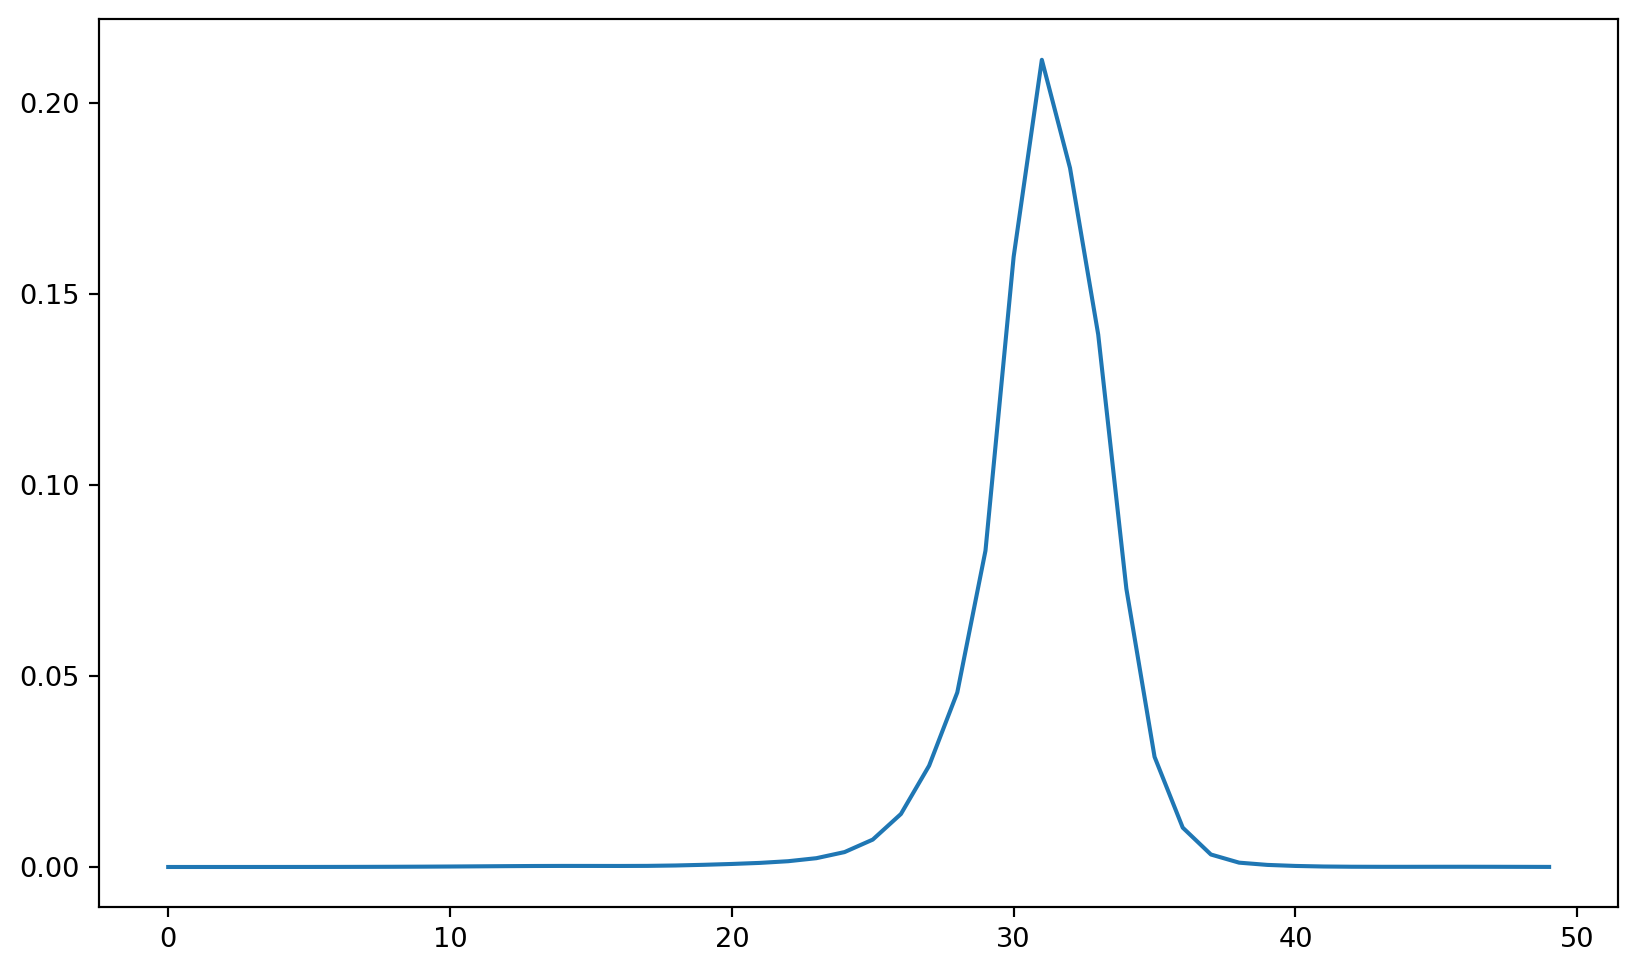

In [88]:
# plt.plot(r)
plt.plot(r2) 
# r['income_mountain'].plot()

In [89]:
def run_resample(x):
    ser_copy = x.droplevel([0, 1])
    # ser_copy = x.copy()
    # print(ser_copy.head())
    return resample_to_50(resample_to_int(ser_copy))

est = estimated.groupby(['country', 'year'])['income_mountain'].apply(run_resample)

In [90]:
est

country  year  bracket
afg      1800  0          0.000011
               1          0.000017
               2          0.000028
               3          0.000047
               4          0.000081
                            ...   
zwe      2050  45         0.000018
               46         0.000011
               47         0.000006
               48         0.000003
               49         0.000001
Name: income_mountain, Length: 2127800, dtype: float64

<AxesSubplot:xlabel='year'>

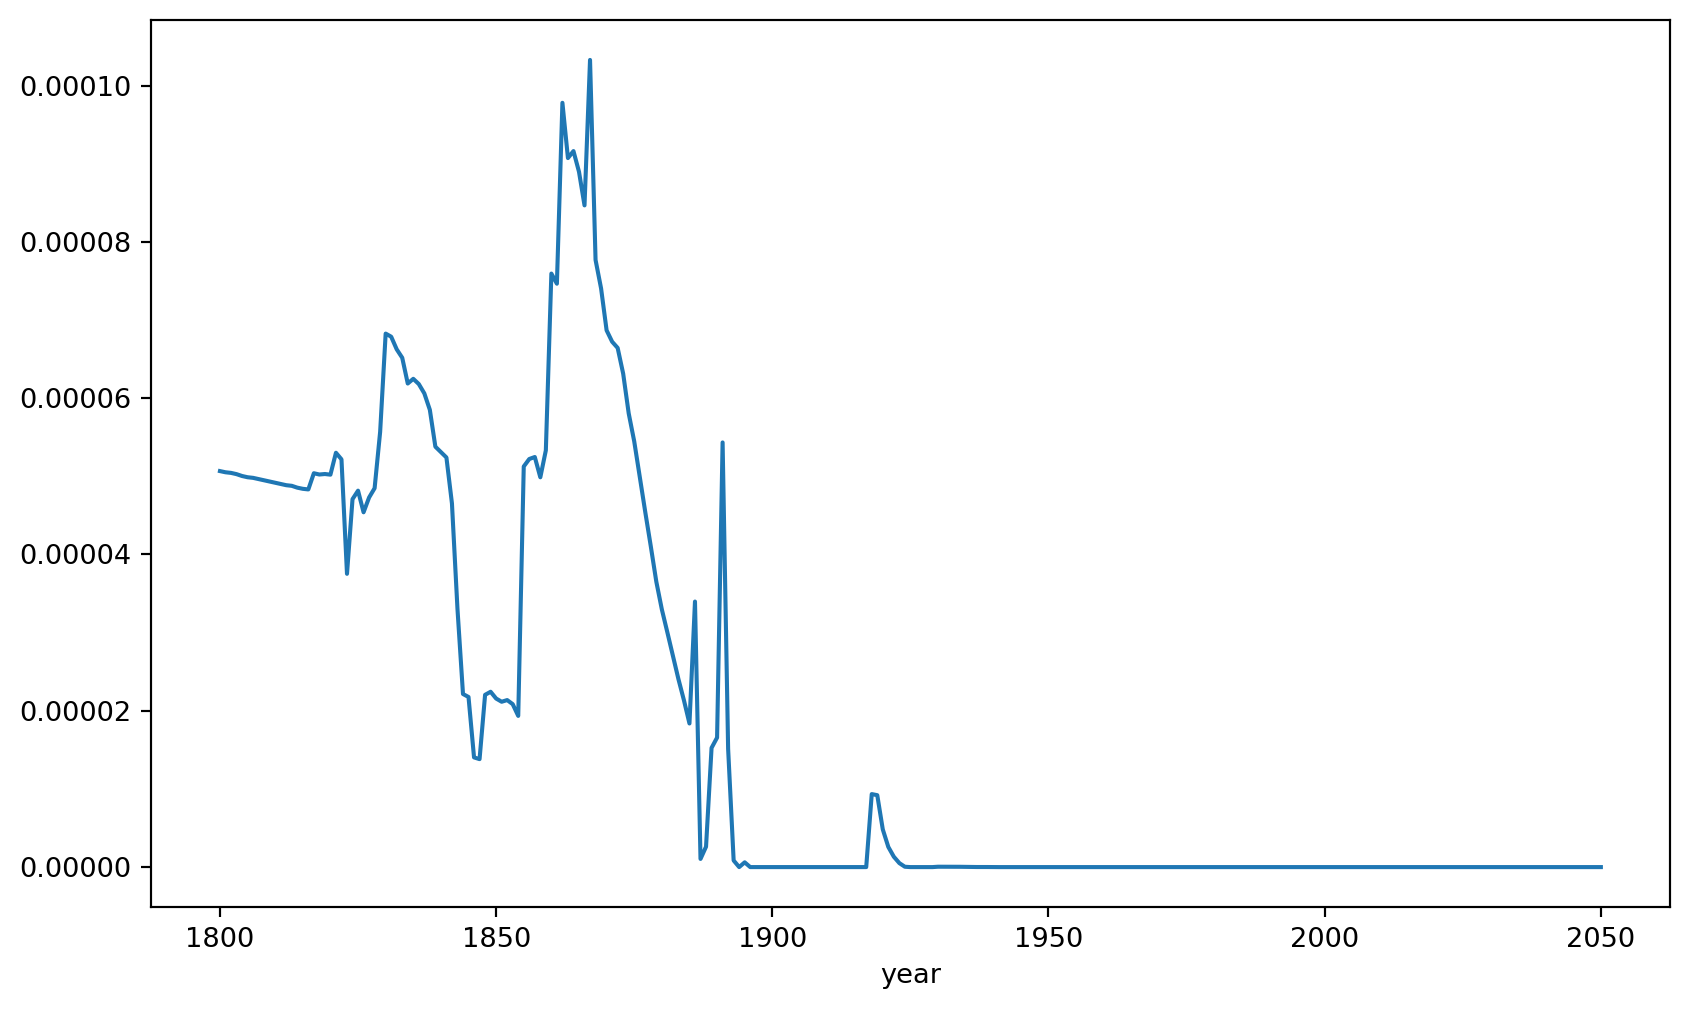

In [91]:
est.loc['rus', :, 0].plot()

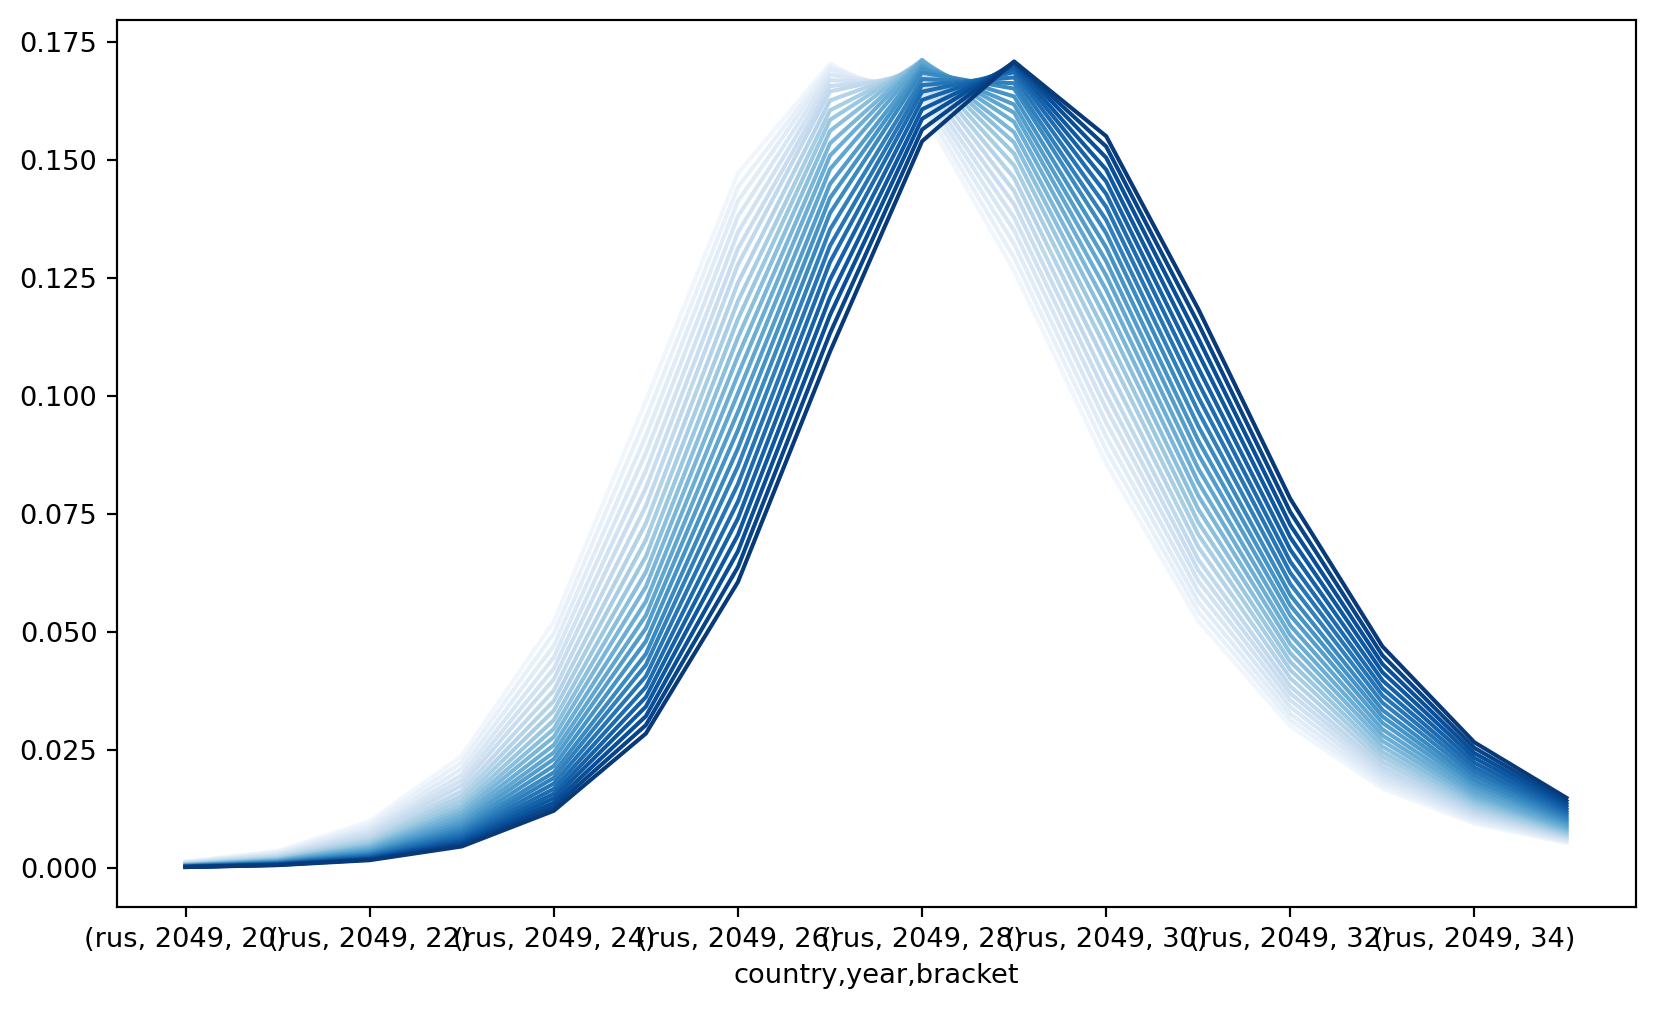

In [92]:
sns.set_palette('Blues', 25)

for i in range(2025, 2050):
    # resample_to_int_kde_2(est.loc['swe', i, :]).plot()
    est.loc['rus', i, 20:35].plot()
    # plt.plot(a.bracket, a.income_mountain)

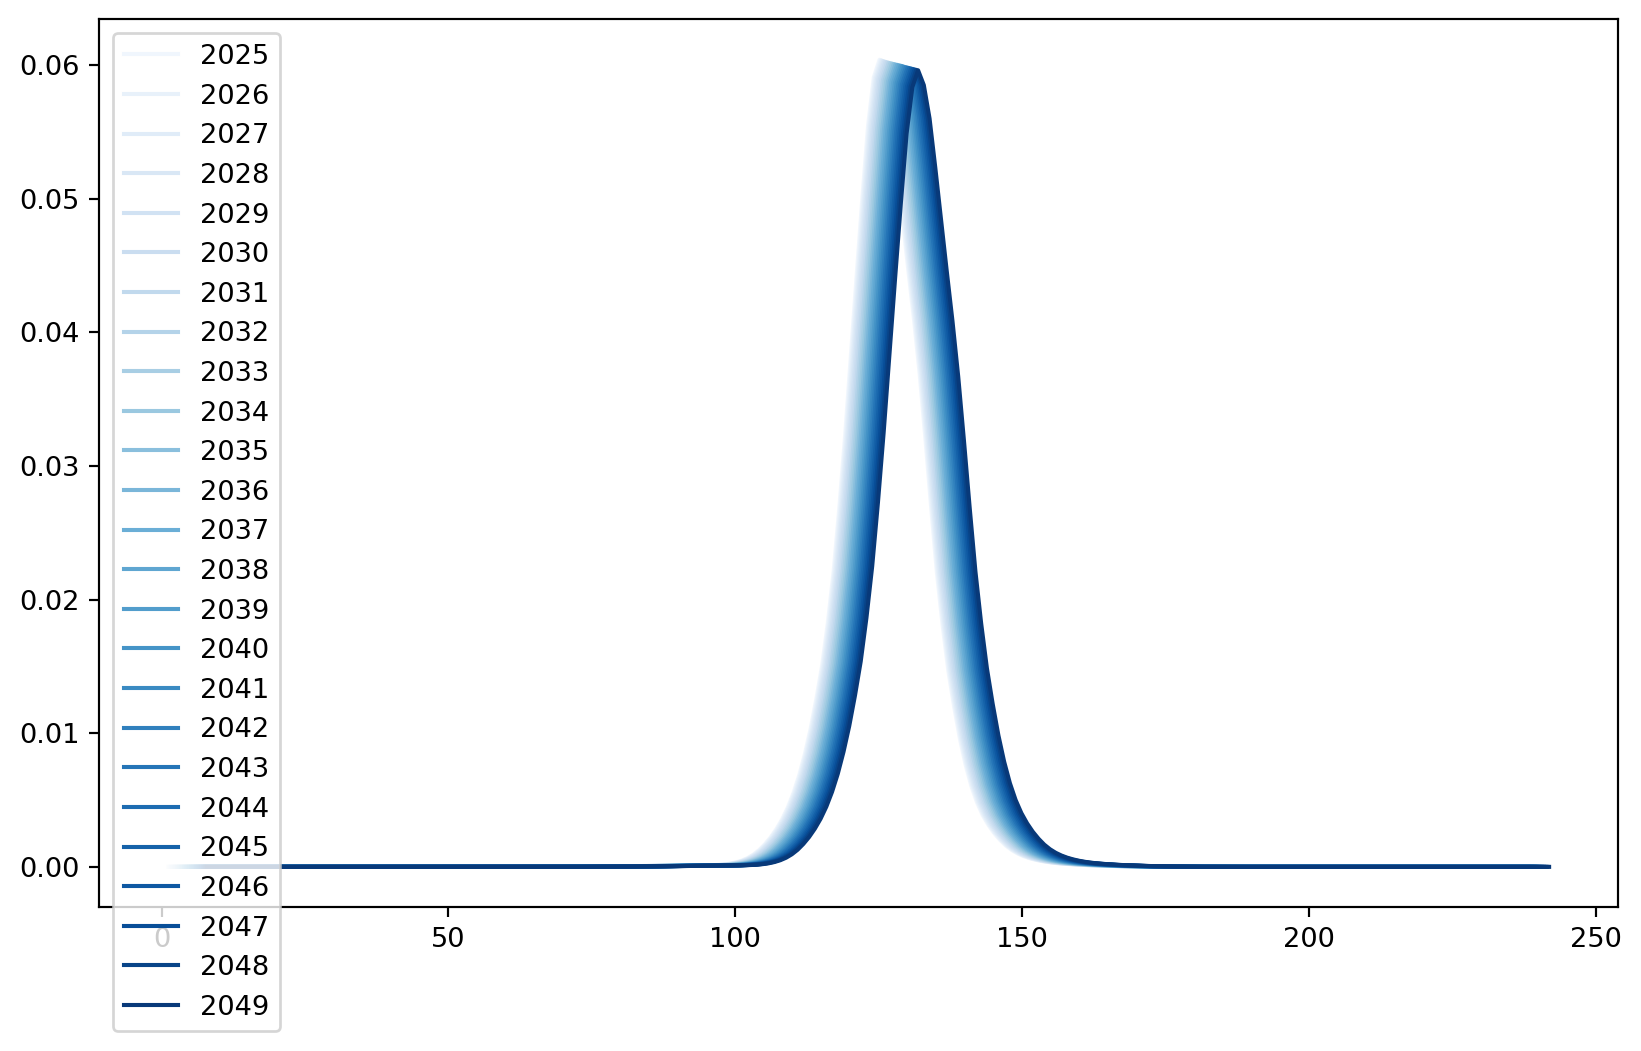

In [95]:
# sns.set_palette('Blues', 10)

for i in range(2025, 2050):
    a = estimated.loc['fin', i].reset_index()
    # b = a[((a.bracket >= 20))]
    plt.plot(a.bracket, a.income_mountain, label=str(i)) 
    
plt.legend()

In [96]:
est[est<0]

Series([], Name: income_mountain, dtype: float64)

In [97]:
res6 # povcal period data

bracket  population_percentage
country year coverage_type                                
ago     1981 n                    0           7.153827e-06
             n                    1           8.619550e-06
             n                    2           1.029801e-05
             n                    3           1.214019e-05
             n                    4           1.423205e-05
...                             ...                    ...
zwe     2019 n                  195           1.402410e-07
             n                  196           1.090947e-07
             n                  197           8.406808e-08
             n                  198           6.417809e-08
             n                  199           4.857008e-08

[1327800 rows x 2 columns]

In [161]:
povcal = []

for c in res6.index.get_level_values('country').unique():
    df = res6.loc[[c]]
    ct_idx = df.index.get_level_values('coverage_type')
    for ct in 'naur':
        if ct in ct_idx:
            df_ = df[ct_idx == ct].copy()
            df_ = df_.reset_index('coverage_type', drop=True)
            povcal.append(df_)
            break

In [162]:
povcal[0].loc[('ago', 1981)].sum()

bracket                  19900.0
population_percentage        1.0
dtype: float64

In [163]:
povcal = pd.concat(povcal).set_index('bracket', append=True)

In [164]:
povcal.columns = ['income_mountain']

In [165]:
povcal

income_mountain
country year bracket                 
ago     1981 0           7.153827e-06
             1           8.619550e-06
             2           1.029801e-05
             3           1.214019e-05
             4           1.423205e-05
...                               ...
zwe     2019 195         1.402410e-07
             196         1.090947e-07
             197         8.406808e-08
             198         6.417809e-08
             199         4.857008e-08

[1281800 rows x 1 columns]

In [166]:
povcal_50 = povcal.groupby(['country', 'year'])['income_mountain'].apply(resample_to_50)

In [167]:
res8 = pd.concat([est.to_frame(), povcal_50.to_frame()])

In [168]:
res8 = res8.sort_index()

In [169]:
res8

income_mountain
country year bracket                 
afg     1800 0               0.000011
             1               0.000017
             2               0.000028
             3               0.000047
             4               0.000081
...                               ...
zwe     2050 45              0.000018
             46              0.000011
             47              0.000006
             48              0.000003
             49              0.000001

[2448250 rows x 1 columns]

In [170]:
res8.index.names = ['geo', 'time', 'income_bracket_50']
res8.columns = ['population_percentage']

In [171]:
res8.to_csv('../../income_mountain/ddf--datapoints--population_percentage--by--geo--time--income_bracket_50.csv')

In [172]:
# res8.to_csv('../../all_shapes_200.csv')  # TODO: formatting

# step 9. change table format

In [173]:
res8.index.names = ['geo', 'time', 'bracket']
res9 = res8.copy()

In [174]:
res9

population_percentage
geo time bracket                       
afg 1800 0                     0.000011
         1                     0.000017
         2                     0.000028
         3                     0.000047
         4                     0.000081
...                                 ...
zwe 2050 45                    0.000018
         46                    0.000011
         47                    0.000006
         48                    0.000003
         49                    0.000001

[2448250 rows x 1 columns]

In [175]:
res9.stack().loc[('ago', 1981)].sum()

0.9999999999999999

# step 10. calculate population count

In [146]:
pop_file = '../../../ddf--gapminder--systema_globalis/countries-etc-datapoints/ddf--datapoints--population_total--by--geo--time.csv'
pop = pd.read_csv(pop_file).set_index(['geo', 'time'])['population_total']

In [176]:
res10 = []
gs = res9.groupby(['geo', 'time'])
for g, df in gs:
    try:
        p = pop.loc[g]
    except KeyError:
        print('no population for: ', g)
        res10.append(None)
        continue
    row_pop = np.round(df * p)
    # row_pop_str = ', '.join(row_pop.astype(int).astype(str))
    res10.append(row_pop)

no population for:  ('kos', 2000)
no population for:  ('kos', 2001)
no population for:  ('kos', 2002)
no population for:  ('kos', 2003)
no population for:  ('kos', 2004)
no population for:  ('kos', 2005)
no population for:  ('kos', 2006)
no population for:  ('kos', 2007)
no population for:  ('kos', 2008)
no population for:  ('kos', 2009)
no population for:  ('kos', 2010)
no population for:  ('kos', 2011)
no population for:  ('kos', 2012)
no population for:  ('kos', 2013)
no population for:  ('kos', 2014)
no population for:  ('kos', 2015)
no population for:  ('kos', 2016)
no population for:  ('kos', 2017)
no population for:  ('kos', 2018)
no population for:  ('kos', 2019)


In [177]:
res10 = pd.concat(res10)

In [178]:
res10

population_percentage
geo time bracket                       
afg 1800 0                         35.0
         1                         56.0
         2                         92.0
         3                        154.0
         4                        266.0
...                                 ...
zwe 2050 45                       443.0
         46                       255.0
         47                       139.0
         48                        71.0
         49                        34.0

[2447250 rows x 1 columns]

In [179]:
res10 = res10.dropna()

In [180]:
res10.columns = ['population']

In [181]:
res10.to_csv('../../income_mountain/ddf--datapoints--population--by--geo--time--income_bracket_50.csv')

In [182]:
res11 = res10.unstack().copy()

In [183]:
res11

population                                                          \
bracket          0     1     2      3      4      5      6       7       8    
geo time                                                                      
afg 1800       35.0  56.0  92.0  154.0  266.0  487.0  929.0  1852.0  3858.0   
    1801       35.0  56.0  92.0  154.0  266.0  487.0  929.0  1852.0  3858.0   
    1802       35.0  56.0  92.0  154.0  266.0  487.0  929.0  1852.0  3858.0   
    1803       35.0  56.0  92.0  154.0  266.0  487.0  929.0  1852.0  3858.0   
    1804       35.0  56.0  92.0  154.0  266.0  487.0  929.0  1852.0  3858.0   
...             ...   ...   ...    ...    ...    ...    ...     ...     ...   
zwe 2046        0.0   0.0   8.0   99.0  208.0  352.0  557.0   859.0  1351.0   
    2047        0.0   0.0   6.0   94.0  209.0  356.0  565.0   870.0  1367.0   
    2048        0.0   0.0   6.0   90.0  212.0  361.0  573.0   880.0  1377.0   
    2049        0.0   0.0   6.0   83.0  213.0  364.0  578.0   888.0  1388.0   
    2050        0.0   2.0  12.0   89.0  233.0  397.0  627.0   960.0  1489.0   

                  ...                                                       \
bracket       9   ...      40      41      42      43     44     45     46   
geo time          ...                                                        
afg 1800  8412.0  ...     5.0     3.0     2.0     1.0    0.0    0.0    0.0   
    1801  8412.0  ...     5.0     3.0     2.0     1.0    0.0    0.0    0.0   
    1802  8412.0  ...     5.0     3.0     2.0     1.0    0.0    0.0    0.0   
    1803  8412.0  ...     5.0     3.0     2.0     1.0    0.0    0.0    0.0   
    1804  8412.0  ...     5.0     3.0     2.0     1.0    0.0    0.0    0.0   
...          ...  ...     ...     ...     ...     ...    ...    ...    ...   
zwe 2046  2213.0  ...  3566.0  2408.0  1564.0   995.0  613.0  363.0  206.0   
    2047  2219.0  ...  3717.0  2515.0  1636.0  1043.0  644.0  383.0  218.0   
    2048  2221.0  ...  3866.0  2612.0  1706.0  1089.0  675.0  403.0  230.0   
    2049  2230.0  ...  4019.0  2710.0  1777.0  1137.0  706.0  423.0  242.0   
    2050  2365.0  ...  4168.0  2807.0  1847.0  1183.0  738.0  443.0  255.0   

                             
bracket      47    48    49  
geo time                     
afg 1800    0.0   0.0   0.0  
    1801    0.0   0.0   0.0  
    1802    0.0   0.0   0.0  
    1803    0.0   0.0   0.0  
    1804    0.0   0.0   0.0  
...         ...   ...   ...  
zwe 2046  110.0  55.0  25.0  
    2047  117.0  59.0  27.0  
    2048  124.0  63.0  30.0  
    2049  132.0  67.0  32.0  
    2050  139.0  71.0  34.0  

[48945 rows x 50 columns]

In [184]:
def row_to_str(row):
    row_str = ', '.join(row['population'].astype(int).astype(str))
    return row_str

res12 = res10.groupby(['geo', 'time']).apply(row_to_str)

In [185]:
res12

geo  time
afg  1800    35, 56, 92, 154, 266, 487, 929, 1852, 3858, 84...
     1801    35, 56, 92, 154, 266, 487, 929, 1852, 3858, 84...
     1802    35, 56, 92, 154, 266, 487, 929, 1852, 3858, 84...
     1803    35, 56, 92, 154, 266, 487, 929, 1852, 3858, 84...
     1804    35, 56, 92, 154, 266, 487, 929, 1852, 3858, 84...
                                   ...                        
zwe  2046    0, 0, 8, 99, 208, 352, 557, 859, 1351, 2213, 3...
     2047    0, 0, 6, 94, 209, 356, 565, 870, 1367, 2219, 3...
     2048    0, 0, 6, 90, 212, 361, 573, 880, 1377, 2221, 3...
     2049    0, 0, 6, 83, 213, 364, 578, 888, 1388, 2230, 3...
     2050    0, 2, 12, 89, 233, 397, 627, 960, 1489, 2365, ...
Length: 48945, dtype: object

In [186]:
res12.name = 'income_mountain_50bracket_shape_for_log'

In [187]:
res12.index.names = ['country', 'time']

In [188]:
res12.to_csv('../../income_mountain/ddf--datapoints--income_mountain_50bracket_shape_for_log--by--country--time.csv')

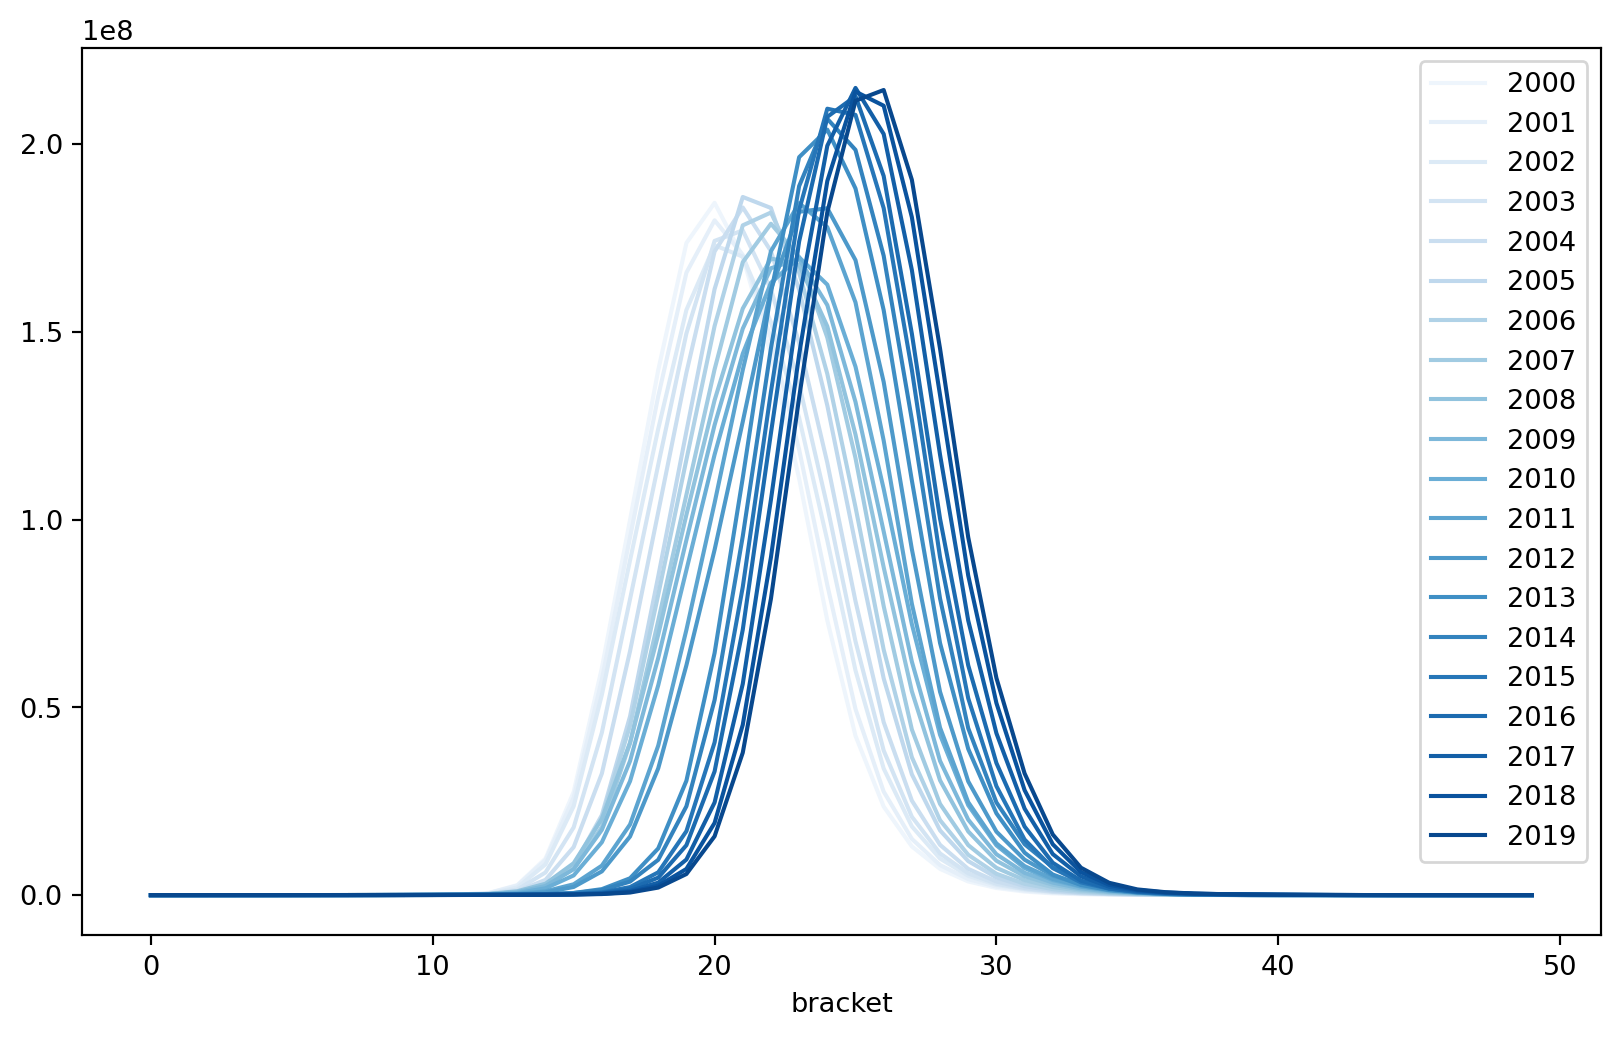

In [191]:
sns.set_palette('Blues', 21)

def run_plot(a, b):
    (res10.loc[(a, b)]['population']).plot(label=b)


for i in range(2000, 2020):
    run_plot('chn', i)
    
plt.legend()